# Exploring the data

My impressions so far:

* The biggest challenge is dealing with the Breed, Color and Name variables
* Many of the variables are going to have interactions with one another, especially the AnimalType variable, therefore it may be useful to use a model that automatically considers feature interactions (ex. a Random Forest) over a model that requires us to manually create feature interactions (ex. Logistic Regression)
* Not a huge number of missing values in the training set, save for animal name, where not knowing the animal's name (or the animal not having a name) certainly tells us something useful...it may be worth imputing neutered and gender?

Data cleaning / feature engineering overview:

* Split `SexuponOutcome` into separate neutered and gender features
* `AgeuponOutcome` is converted into a numeric feature
* `DateTime` is converted into a set of date-specific features (year, month, day of the week, etc.)
* Find strategies for classifying `Breed` into clusters/taxonomies for dogs and cats separately, this may be difficult

In [1]:
%matplotlib inline

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import sklearn
from wordcloud import WordCloud, STOPWORDS

train = pd.read_csv('data/train.csv')

## Overview

See what the data look like.

In [2]:
print 'Number of training observations:', len(train.index)
train.describe()

Number of training observations: 26729


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


Missing values by column:

In [3]:
train.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

## Examining the dependent variable, `OutcomeType`

What happened to the animals?

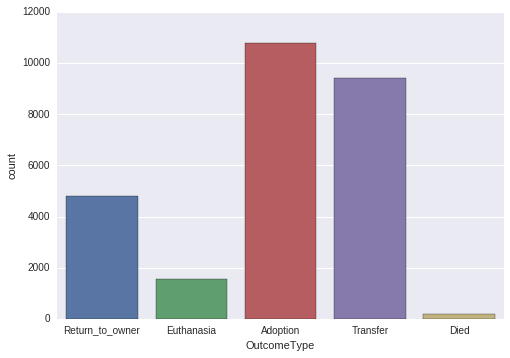

In [4]:
sns.countplot(x = "OutcomeType", data = train)

## Examining the independent variables

### `AnimalType`

Whether it's a cat or a dog.

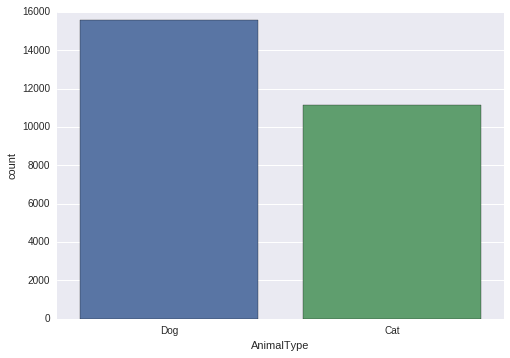

In [5]:
sns.countplot(x = "AnimalType", data = train)

`OutcomeType` by `AnimalType` (relative frequency)

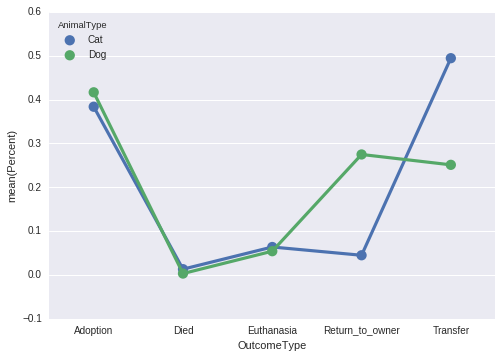

In [6]:
def rel_freq_plot(train, column):
    sns.pointplot(x = 'OutcomeType', y = 'Percent', hue = column, data = (train
        .groupby(['OutcomeType', column])
        .size()
        .reset_index()
        .rename(columns = {0: 'Count'})
        .merge(
            (train
             .groupby([column])
             .size()
             .reset_index()
             .rename(columns = {0: 'Total'})
            ), how = 'inner', on = column)
        .assign(Percent = lambda x: x.Count / x.Total)
    ))
    
rel_freq_plot(train, 'AnimalType')

Dogs are more likely to be returned to their owners and less likely to be transferred than cats.

### `SexuponOutcome`

This variable measures the sex of the animal as well as whether or not it is able to reproduce at the time of the outcome.

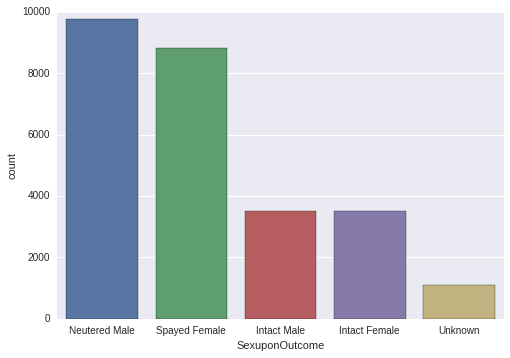

In [7]:
sns.countplot(x = "SexuponOutcome", data = train)

I'm thinking that these should be split into the following 2 variables instead of being in a single variable:

* Sex - Male / Female
* NeuteredSprayed - True / False

In [8]:
def create_sex_variables(data):
    SexuponOutcome = data['SexuponOutcome'].fillna('Unknown')
    results = []
    for row in SexuponOutcome:
        row = row.split(' ')
        if len(row) == 1:
            row = ['Unknown', 'Unknown']
        results.append(row)
    NeuteredSprayed, Sex = zip(
        *[['Neutered', x[1]] if x[0] == 'Spayed' else x for x in results])
    return (data.assign(Neutered = NeuteredSprayed).assign(Sex = Sex)
            .drop(['SexuponOutcome'], axis = 1))

train = train.pipe(create_sex_variables)

Quick look at the distribution of Neutered animals, and how being neutered affects outcomes:

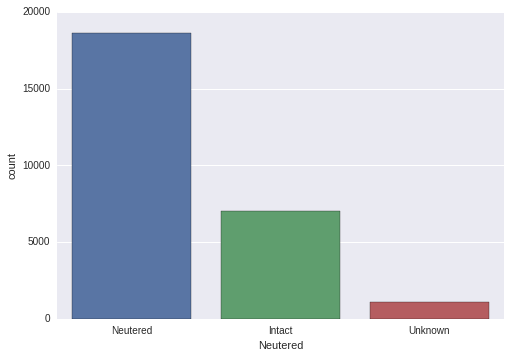

In [9]:
sns.countplot(x = "Neutered", data = train)

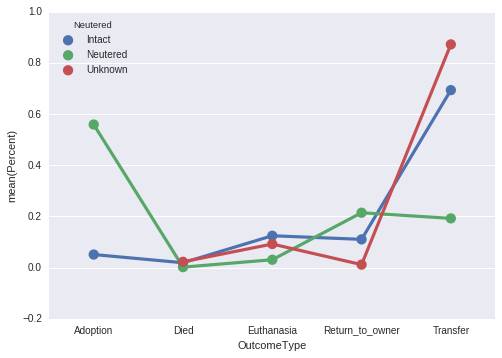

In [10]:
rel_freq_plot(train, 'Neutered')

Quick look at the distribution of animal gender, and how gender affects outcomes:

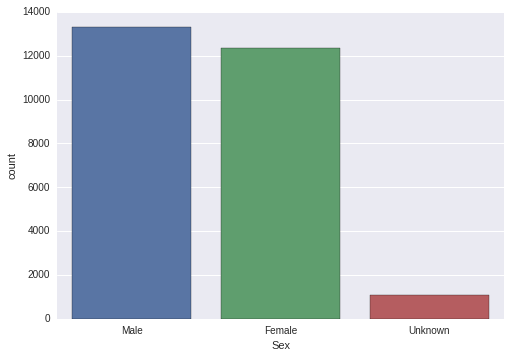

In [11]:
sns.countplot(x = "Sex", data = train)

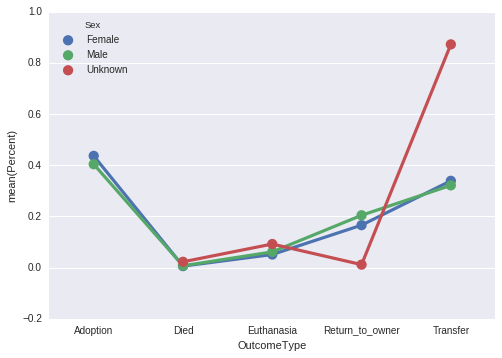

In [12]:
rel_freq_plot(train, 'Sex')

### `AgeuponOutcome` 

Should be transformed into a numerical variable. There are 18 NAs - given how few, let's not worry too much about them and just impute the median.

In [13]:
def create_age_in_years(ages):
    results = []
    units = {'days': 365.0, 'weeks': 52.0, 'months': 12.0}
    for age in ages:
        if age == 'NA':
            results.append('NA')
        else:
            duration, unit = age.split(' ')
            results.append(float(duration) / units.get(unit, 1.0))
    impute = np.median([age for age in results if age != 'NA'])
    return [age if age != 'NA' else impute for age in results]

train = (train
         .assign(Age = create_age_in_years(list(train['AgeuponOutcome'].fillna('NA'))))
         .drop(['AgeuponOutcome'], axis = 1))

Look at the distribution of ages:

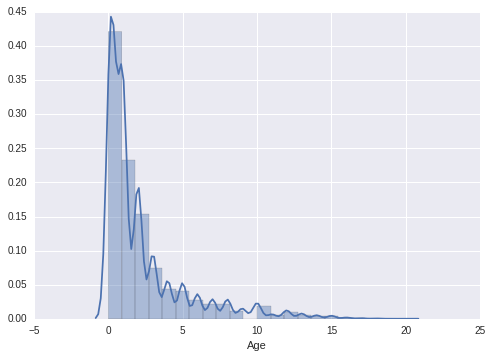

In [14]:
sns.distplot(train['Age'], bins = 22)

The right skew makes sense in the context of age. If we do a log transformation, can we eliminate the skew so that age follows a roughly Gaussian distribution?

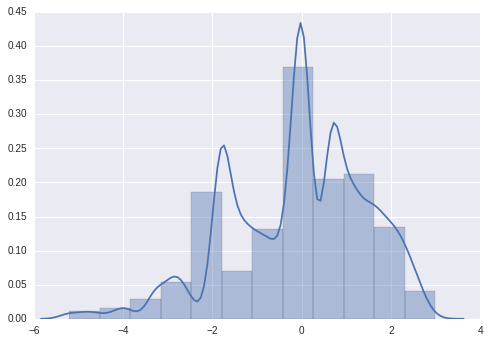

In [15]:
sns.distplot([x if x == 0 else np.log(x) for x in train['Age']], bins = 12)

Are the cats in shelters older than dogs, or vice versa?

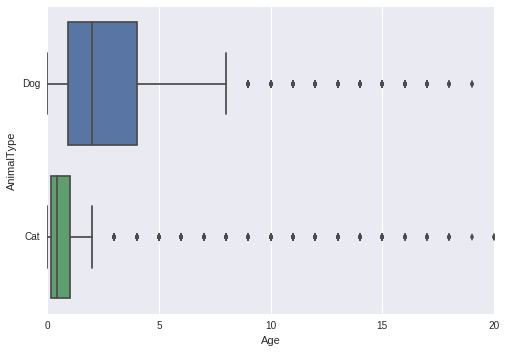

In [16]:
sns.boxplot(x = "Age", y = "AnimalType", data = train);

Let's quickly take a look at how age affects outcome:

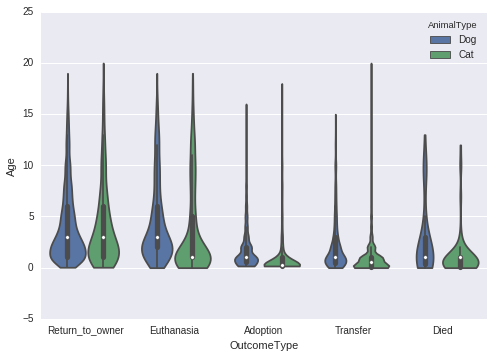

In [17]:
sns.violinplot(x = "OutcomeType", y = "Age", hue = "AnimalType", data = train, cut = 0, split = False)

Animals returned to their owners tend to be slightly older. Cats are dying, being adopted, and being transferred at a younger age.

### `DateTime`

We want to split this into multiple variables:

* Year, month, day of the week, time (morning, afternoon, evening, night)

In [18]:
def time_of_day(hour):
    if hour > 4 and hour < 12:
        return 'morning'
    elif hour >= 12 and hour < 18:
        return 'afternoon'
    else:
        return 'evening/night'
    
def day_of_the_week(DateTime):
    return datetime.datetime.strptime(DateTime, '%Y-%m-%d %H:%M:%S').weekday()

train = (train
         .assign(Year = train.DateTime.map(lambda x: x[:4]))
         .assign(Month = train.DateTime.map(lambda x: x[5:7]))
         .assign(Day = train.DateTime.map(lambda x: day_of_the_week(x)))
         .assign(TimeOfDay = train.DateTime.map(lambda x: time_of_day(int(x[11:13]))))
         .drop(['DateTime'], axis = 1))

Day of the week (0 is Monday, 6 is Sunday)

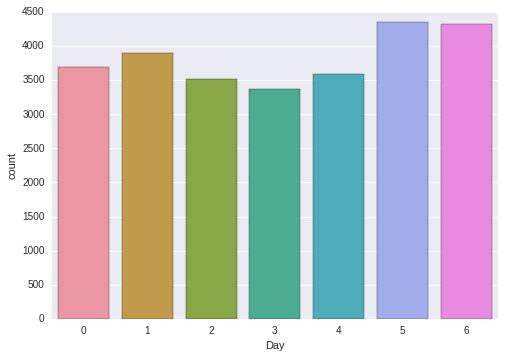

In [19]:
sns.countplot(x = "Day", data = train)

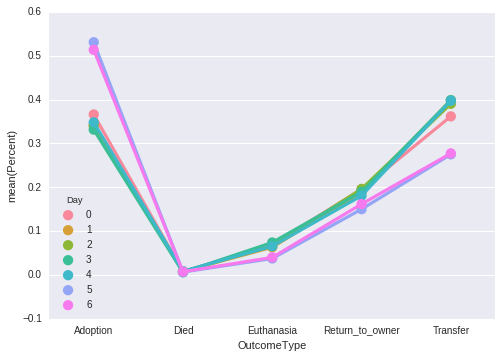

In [20]:
rel_freq_plot(train, 'Day')

Time of the day

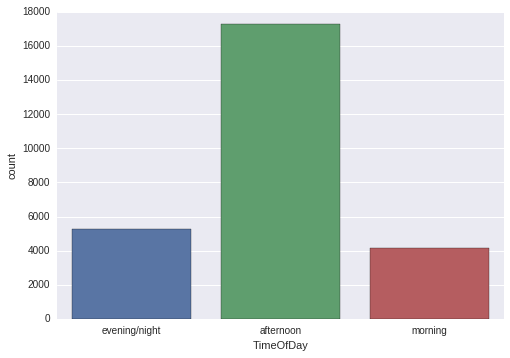

In [21]:
sns.countplot(x = "TimeOfDay", data = train)

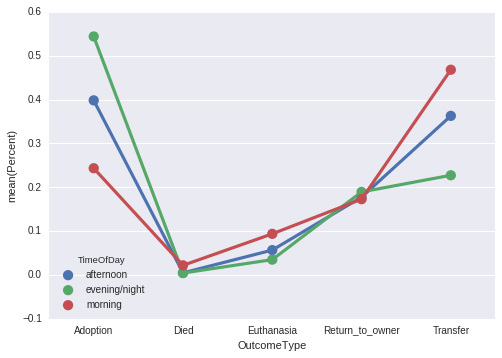

In [22]:
rel_freq_plot(train, 'TimeOfDay')

## Breed

Breed only makes sense in the context of the animal species, of `AnimalType`

In [23]:
print 'Total number of breeds:', len(train['Breed'].unique())
print 'Number of cat breeds:', len(train[train['AnimalType'] == 'Cat']['Breed'].unique())
print 'Number of dog breeds:', len(train[train['AnimalType'] == 'Dog']['Breed'].unique())

Total number of breeds: 1380
Number of cat breeds: 60
Number of dog breeds: 1320


Given the massive number of breeds (mostly for dogs) I am worried about overfitting w/ regard to breed. Here is the distribution of the (log) number of animals by breed for both animals. We can see there are a small number of breeds containing a large number of animals, and then many breeds with a very small number of animals.

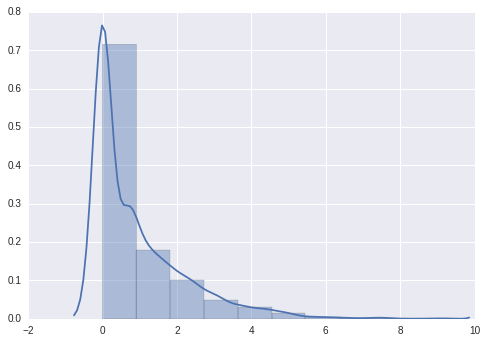

In [24]:
sns.distplot(np.log(train.groupby('Breed').size().values), bins = 10)

*Dog Breeds*

Let's look at the names of the top breeds to see if we can get any ideas around how to structure this feature.

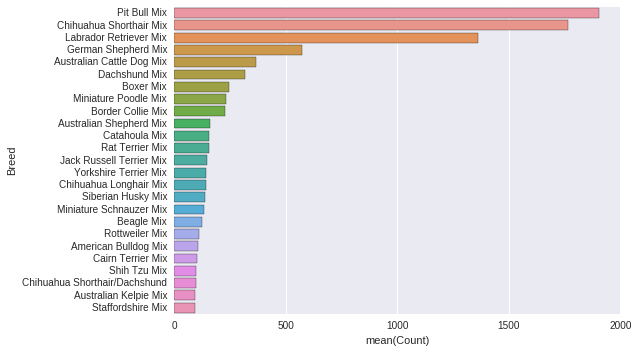

In [25]:
sns.barplot(x = "Count", y = "Breed", data = (
        train[train['AnimalType'] == 'Dog']
        .groupby(['Breed'])
        .size()
        .reset_index()
        .rename(columns = {0: 'Count'})
        .sort_values(['Count'], ascending = False)
        .head(n = 25)))

Let's try splitting the breed names into words, and seeing which words show up frequently.

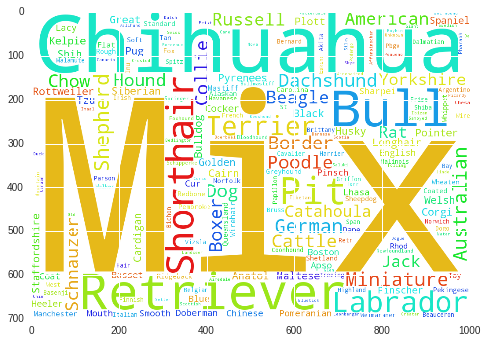

In [26]:
def wordcount_dict(wordlist):
    results = {}
    for item in wordlist:
        item = re.split('\W+', item)
        for word in item:
            try:
                results[word] += 1
            except:
                results[word] = 1
    return results

def wordcloud_string(wordcount_dict):
    final_list = []
    for word, count in wordcount_dict.items():
        final_list += [word] * count
    return ' '.join(final_list)

def display_wordcloud(wordcloud_string):
    wordcloud = (
        WordCloud(background_color = 'white', stopwords = STOPWORDS, height = 700, width = 1000)
        .generate(wordcloud_string))
    plt.imshow(wordcloud)
    plt.show()
    return None

display_wordcloud(wordcloud_string(
        wordcount_dict(list(train.query('AnimalType == "Dog"')['Breed']))))

Mix (mix-breed, as opposted to a pure-breed) is the most common word, not surpringly. Now that I am looking at this, I wonder if using n-grams in addition to pure words would give us additional information?

Let's see how many breeds there are for dogs when we split names on forward slashes and remove the word 'Mix':

In [27]:
def common_breeds(breeds):
    breed_counts = {}
    for breed in breeds:
        breed = breed.replace(' Mix', '').split('/')
        for subbreed in breed:
            try:
                breed_counts[subbreed] += 1
            except:
                breed_counts[subbreed] = 1
    return breed_counts

breed_counts = common_breeds(list(train[train['AnimalType'] == 'Dog']['Breed']))

Number of dog breeds with >= 30 animals (including mixed breeds) in the training set:

In [28]:
len([breed for breed, count in breed_counts.items() if count >= 30])

71

**I further tackle dog breeds in the file `2-dog-breeds.ipynb`.**

*Cat breeds*

There are few enough cat breeds that we may be able to manually create features that capture much of the information in breed - the things that come to mind are:

* Mix vs non-mix
* Short/medium/long hair

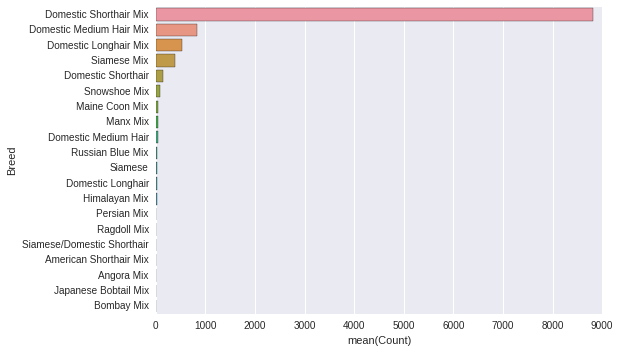

In [29]:
sns.barplot(x = "Count", y = "Breed", data = (
        train[train['AnimalType'] == 'Cat']
        .groupby(['Breed'])
        .size()
        .reset_index()
        .rename(columns = {0: 'Count'})
        .sort_values(['Count'], ascending = False)
        .head(n = 20)))

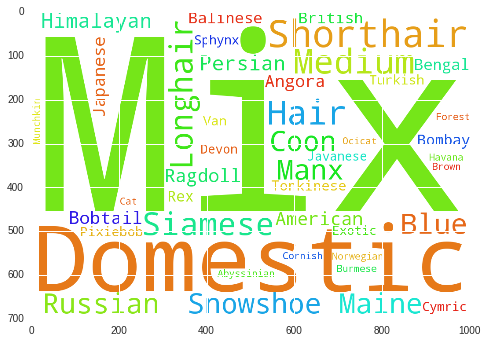

In [30]:
display_wordcloud(wordcloud_string(
        wordcount_dict(list(train.query('AnimalType == "Cat"')['Breed']))))

How many cat breeds are there (including mixes) with >= 30 animals in the training set?

In [31]:
breed_counts = common_breeds(list(train[train['AnimalType'] == 'Cat']['Breed']))
len([breed for breed, count in breed_counts.items() if count >= 30])

8

### `Color`

I'm guessing that color's affect on the outcome is sometimes dependent on the animal type, and sometimes not, as in some colors may be appreciated across enmails, while some may be animal specific. Given the likely interactions between variables I would consider a model that considers interactions (neural networks, decisions trees) vs. a model that doesn't take these interactions into account automatically (logistic regression, KNN).

In [32]:
print 'Number of colors:', len(train['Color'].unique())
train['Color'].unique()[:10]

Number of colors: 366


array(['Brown/White', 'Cream Tabby', 'Blue/White', 'Blue Cream', 'Tan',
       'Black/Tan', 'Blue Tabby', 'Brown Tabby', 'Red/White', 'White'], dtype=object)

Note that /'s separate cases where an animal is multiple colors, so let's see animal counts by color (this count will be higher than the number of training examples since animal's coats can contain multiple colors).

Number of distinct colors: 36


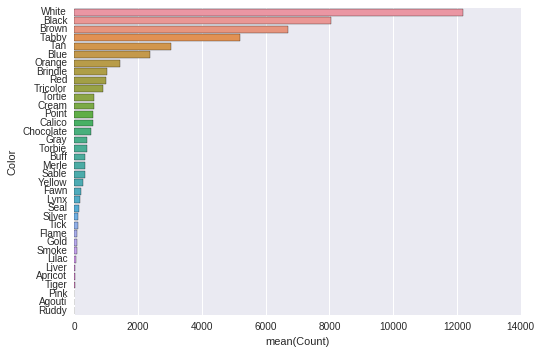

In [33]:
colors = {}
for color in list(train['Color']):
    color = re.split('\W+', color)
    for subcolor in color:
        try:
            colors[subcolor] += 1
        except:
            colors[subcolor] = 1
            
print 'Number of distinct colors:', len(colors)
sns.barplot(y = "Color", x = "Count", 
            data = (pd.DataFrame(colors.items(), columns=['Color', 'Count'])
                    .sort_values(['Count'], ascending = False)))

36 isn't a huge number of features. It probably makes sense split these into 36 binary features, where a training example may have 1's for multiple color features. Like many of these other variables, there are likely interactions between these features (ex. a difference between brown, gold, and gold/brown).

### `Name`

My intuition is that a name itself isn't that important in relation to animal outcome, though I see two areas where the name may matter:

* Whether or not the animal even has a name (or the shelters knows the name) - animals with no names may have been more poorly treated, which could affect the animal outcome, and
* How common the animal's name is

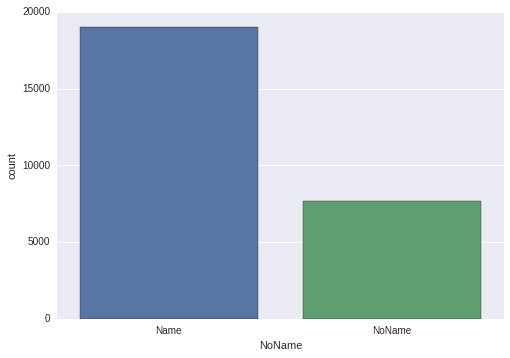

In [34]:
train['NoName'] = np.where(train['Name'].isnull(), 'NoName', 'Name')
sns.countplot(x = "NoName", data = train)

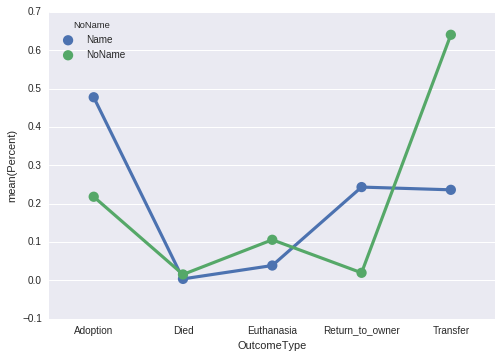

In [35]:
rel_freq_plot(train, 'NoName')

Animals without names are less likely to be adopted or returned to their owners and more likely to be euthanised or transferred.

Names wordcloud:

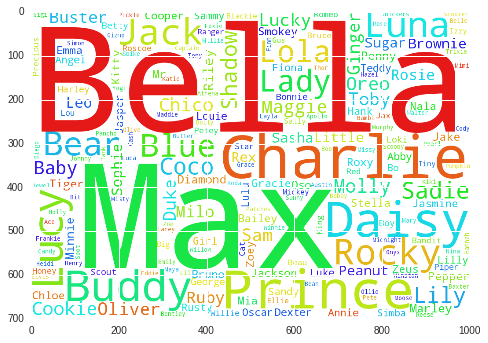

In [36]:
display_wordcloud(wordcloud_string(
        wordcount_dict(list(train[train['Name'].notnull()]['Name']))))

## Next steps

With that, it's time to start engineering the features in preparation for building the model.